### 实验2_前馈神经网络实验 多分类任务

In [18]:
import torch
import torchvision
import torch.utils.data as Data
import torch.optim as optim
import numpy as np
from torch import nn
from typing import Tuple
from matplotlib import pyplot as plt
import torchvision.transforms as transforms


def train_epoch(data_loader: Data.DataLoader, net: nn.Module,
                loss_func, optimizer: torch.optim.Optimizer,
                device='cpu'):
    """
    训练迭代一次
    :param data_loader: 生成器 (x, y)
    :param net:         模型
    :param loss_func:   损失函数
    :param optimizer:   优化器
    :param device:      设备
    :return:    loss, acc
    """
    net.train()
    train_batch_num = len(data_loader)

    # 一次迭代中的 Loss、正确样本数、总样本数
    total_loss, correct, sample_num = 0, 0, 0

    for batch_num, (x, y_true) in enumerate(data_loader):

        # 将数据放入指定的设备
        x = x.to(device).float()
        y_true = y_true.to(device).long()

        # 计算损失
        y_hat: torch.Tensor = net(x)
        loss = loss_func(y_hat, y_true)

        # 取概率最大的类别索引
        y_true: torch.Tensor = y_true.view(-1)
        y_hat = y_hat.argmax(dim=1)

        # 反向传播
        optimizer.zero_grad() #清空梯度
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (y_true == y_hat).float().sum().item()
        sample_num += len(y_true)

    loss = total_loss / train_batch_num
    acc = correct / sample_num

    return loss, acc


def test_epoch(data_loader: Data.DataLoader,
               net: nn.Module, loss_func, device='cpu'):
    """
    测试函数迭代一次
    :param data_loader: 生成器 (x, y)
    :param net:         模型
    :param loss_func:   损失函数
    :param device:      设备
    :return:    loss, acc
    """
    net.eval()
    train_batch_num = len(data_loader)

    # 一次迭代中的 Loss、正确样本数、总样本数
    total_loss, correct, sample_num = 0, 0, 0

    with torch.no_grad():

        for batch_num, (x, y_true) in enumerate(data_loader):

            # 将数据放入指定的设备
            x = x.to(device).float()
            y_true = y_true.to(device).long()

            # 计算损失
            y_hat: torch.Tensor = net(x)
            loss = loss_func(y_hat, y_true)

            # 取概率最大的类别索引
            y_true: torch.Tensor = y_true.view(-1)
            y_hat = y_hat.argmax(dim=1)

            total_loss += loss.item()
            correct += (y_true == y_hat).float().sum().item()
            sample_num += len(y_true)

    loss = total_loss / train_batch_num
    acc = correct / sample_num

    return loss, acc


def plot_loss_accuracy(train_loss_list, train_acc_list,
                       test_loss_list, test_acc_list, info=''):
    """
    绘制 训练集和测试集正确率、损失值 的图形
    """
    x = np.linspace(0, len(train_loss_list), len(train_loss_list))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 6)
    if info:
        info = info + ' '

    ax1.plot(x, train_loss_list, 'b-', label="train_loss", lw=1)
    ax1.plot(x, test_loss_list, 'r-', label="test_loss", lw=1)
    ax1.set_title(info + 'Loss')
    ax1.legend(loc='best', frameon=False)
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("Loss")

    ax2.plot(x, train_acc_list, 'b-', label="train_accuracy", lw=1)
    ax2.plot(x, test_acc_list, 'r-', label="test_accuracy", lw=1)
    ax2.set_title(info + 'Accuracy')
    ax2.legend(loc='best', frameon=False)
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("Accuracy")

    plt.show()


def plot_by_dict(metrics: dict, shape: Tuple[int, int]):
    """
    绘制图形 {指标: {参数值名1: [], 参数值名2: []}}
    """
    fig, axes = plt.subplots(shape[0], shape[1])
    axes = list(np.array(axes).ravel())
    fig.set_size_inches(10*shape[0], 6*shape[1])

    colors = ['b', 'r', 'y', 'c', 'k', 'g', 'w', 'm']
    for ax_no, title in enumerate(metrics.keys()):
        ax = axes[ax_no]
        for i, (key, values) in enumerate(metrics.get(title, {}).items()):
            x = np.linspace(0, len(values), len(values))
            ax.plot(x, values, colors[i], label=key, lw=1)
            ax.set_title(title)
            ax.legend(loc='best', frameon=False)
            ax.set_xlabel("epoch")
            ax.set_ylabel(title.lower().split(' ')[-1])

    plt.show()


#### MNIST手写体数据集介绍
+ 该数据集包含60,000个用于训练的图像样本和10,000个用于测试的图像样本。
+ 图像是固定大小(28x28像素)，其值为0到1。 为每个图像都被平展并转换为784(28 * 28)个特征的一维numpy数组。

In [2]:
# dataset_dir = '/Users/zhengchubin/PycharmProjects/learn/data/'
dataset_dir = '/root/zhengchubin/data/'

# 下载不了数据集
# mnist_train = torchvision.datasets.FashionMNIST(root=dataset_dir, train=True, download=True, transform=transforms.ToTensor())
# mnist_test = torchvision.datasets.FashionMNIST(root=dataset_dir, train=False, download=True, transform=transforms.ToTensor())

# 手动下载数据集并读取
mnist_train = torchvision.datasets.FashionMNIST(root=dataset_dir, train=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root=dataset_dir, train=False, transform=transforms.ToTensor())

mnist_train, mnist_train.data.shape, mnist_train.targets.shape

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: /root/zhengchubin/data/
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 torch.Size([60000, 28, 28]),
 torch.Size([60000]))

#### 手动实现前馈神经网络
分析实验结果并绘制训练集和测试集的loss曲线

epoch 0, train_loss 2.150594, test_loss 1.865519, train_acc 0.407050, test_acc 0.479200
epoch 1, train_loss 1.516615, test_loss 1.261692, train_acc 0.574417, test_acc 0.601500
epoch 2, train_loss 1.108952, test_loss 1.004578, train_acc 0.641333, test_acc 0.642700
epoch 3, train_loss 0.927744, test_loss 0.883860, train_acc 0.666750, test_acc 0.663300
epoch 4, train_loss 0.835309, test_loss 0.814375, train_acc 0.687767, test_acc 0.686900
epoch 5, train_loss 0.778121, test_loss 0.769595, train_acc 0.710817, test_acc 0.702100
epoch 6, train_loss 0.735373, test_loss 0.730435, train_acc 0.734717, test_acc 0.723800
epoch 7, train_loss 0.701451, test_loss 0.700659, train_acc 0.751083, test_acc 0.745100
epoch 8, train_loss 0.672057, test_loss 0.671529, train_acc 0.765117, test_acc 0.758700
epoch 9, train_loss 0.646436, test_loss 0.650121, train_acc 0.776883, test_acc 0.767400
epoch 10, train_loss 0.624888, test_loss 0.630073, train_acc 0.787033, test_acc 0.778000
epoch 11, train_loss 0.605206, 

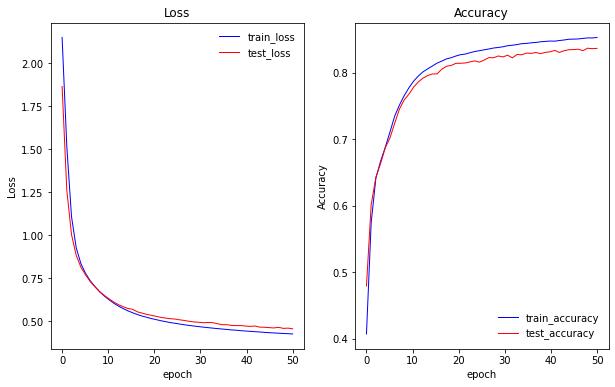

In [4]:
def sgd(lr, *params):
    """
    优化器-梯度下降
    :param lr:          学习率
    :param params:      参数列表
    :return:
    """
    for param in params:
        # 注意这里更改param时用的param.data
        param.data -= lr * param.grad

def softmax(z: torch.Tensor):
    """
    激活函数
    z = w^T * x+ b: [batch_size, ],
    :return [batch_size, num_classes]
    """
    exp_ = torch.exp(z)
    exp_sum = exp_.sum(dim=1, keepdim=True)
    return exp_ / exp_sum

def cross_entropy(y_hat: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    """
    损失函数-交叉熵
    :param y_hat(one_hot):   预测值 (batch_size, class_num)
    :param y_true:           真值  (batch_size)
    :return:
    """
    return -torch.log(y_hat.gather(dim=1, index=y_true.view(-1, 1))) / y_hat.shape[0]


def relu(x: torch.Tensor):
    """
    线性单元
    :param x:
    :param gamma:
    :return:
    """
    return torch.where(x >= 0, x, torch.zeros(x.size()))

def neural_net(x: torch.Tensor, *params) -> torch.Tensor:
    """
    前馈神经网络
    :param x:       特征
    :param params:  模型参数
    :return:
    """
    w1, b1, w2, b2 = params
    # hidden = tanh(torch.mm(x, w1) + b1)
    # hidden = leak_relu(torch.mm(x, w1) + b1)
    hidden = relu(torch.matmul(x, w1) + b1)
    return softmax(torch.matmul(hidden, w2) + b2)


def evaluate_loss_acc(data_iter, net, loss_fn, *params):
    """
    返回测试集的loss
    :return:
    """
    test_l_sum, acc_sum, num_batch, n = 0.0, 0.0, 0, 0
    for x, y_true in data_iter:

        x = x.view(x.shape[0], -1)
        y_hat = net(x, *params)

        test_l_sum += loss_fn(y_hat, y_true).sum()

        y_hat = y_hat.argmax(dim=1)
        acc_sum += (y_hat == y_true).float().sum().item()

        num_batch += 1
        n += y_true.shape[0]

    return test_l_sum/num_batch, acc_sum/n


# 参数配置
num_inputs = 28 * 28
num_hiddens = 256
num_outputs = 10

batch_size = 256
num_epochs = 50
lr = 0.01
net = neural_net
loss = cross_entropy

# 模型训练 w = [w_0, ..., w_n]
w1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)),
                  dtype=torch.float32)
b1 = torch.zeros(num_hiddens, dtype=torch.float32)
w2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)),
                  dtype=torch.float32)
b2 = torch.zeros(num_outputs, dtype=torch.float32)

params = (w1, b1, w2, b2)
for param in params:
    param.requires_grad_(requires_grad=True)

iter_train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
iter_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in range(num_epochs):

    # 一批次的训练数据
    train_l_sum, train_acc_sum, num_batch, n = 0.0, 0.0, 0, 0
    for X, y_true in iter_train:

        # 模型预测值
        X = X.view(-1, num_inputs)
        y_hat:torch.Tensor = net(X, *params)

        # 损失值
        l = loss(y_hat, y_true).sum()

        # 反向传播
        l.backward()

        # 随机梯度下降
        sgd(lr, *params)

        # 梯度置零
        for param in params:
            param.grad.data.zero_()

        y_hat = y_hat.argmax(dim=1)
        train_acc_sum += (y_hat == y_true).float().sum().item()
        train_l_sum += l

        num_batch += 1
        n += y_true.shape[0]

    train_l = train_l_sum / num_batch
    train_acc = train_acc_sum / n
    test_l, test_acc = evaluate_loss_acc(iter_test, net, loss, *params)

    train_loss.append(train_l.detach().numpy())
    test_loss.append(test_l.detach().numpy())
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    print('epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
          % (epoch+1, train_l, test_l, train_acc, test_acc))

plot_loss_accuracy(train_loss, train_accuracy, test_loss, test_accuracy)


#### torch.nn实现前馈神经网络
分析实验结果并绘制训练集和测试集的loss曲线

In [23]:
class FlattenLayaer(nn.Module):
    """ 展开 """
    def __init__(self):
        super(FlattenLayaer, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)


class TorchNeuron(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,
                 activation=nn.ReLU, num_layers=1, drop_out_rate=0):
        super(TorchNeuron, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.activation = activation
        self.drop_out_rate = drop_out_rate

        self.linear = nn.Sequential(*self.create_linear_layers())

        for param in self.linear.parameters():
            nn.init.normal_(param, std=0.01)

    def create_linear_layers(self) -> Tuple[nn.Module]:
        """
        创建层
        :return:
        """
        modules = [
            FlattenLayaer(),
            nn.Linear(self.input_size, self.hidden_size),
            self.activation(),
            nn.Dropout(self.drop_out_rate),
        ]
        for i in range(self.num_layers - 1):
            modules.append(nn.Linear(self.hidden_size, self.hidden_size))
            modules.append(self.activation())
            modules.append(nn.Dropout(self.drop_out_rate))
        modules.append(nn.Linear(self.hidden_size, self.output_size))
        return tuple(modules)

    def forward(self, x):
        return self.linear(x)

epoch 1, train_loss 2.147905, test_loss 1.859626, train_acc 0.295350, test_acc 0.474300
epoch 2, train_loss 1.518830, test_loss 1.269429, train_acc 0.575583, test_acc 0.610700
epoch 3, train_loss 1.115121, test_loss 1.019276, train_acc 0.643100, test_acc 0.647200
epoch 4, train_loss 0.931938, test_loss 0.888740, train_acc 0.671117, test_acc 0.666000
epoch 5, train_loss 0.836167, test_loss 0.822750, train_acc 0.692017, test_acc 0.690200
epoch 6, train_loss 0.776788, test_loss 0.764691, train_acc 0.715617, test_acc 0.713200
epoch 7, train_loss 0.733509, test_loss 0.744313, train_acc 0.737200, test_acc 0.736800
epoch 8, train_loss 0.698171, test_loss 0.699897, train_acc 0.753133, test_acc 0.749000
epoch 9, train_loss 0.669169, test_loss 0.676027, train_acc 0.765700, test_acc 0.762000
epoch 10, train_loss 0.643758, test_loss 0.658022, train_acc 0.778100, test_acc 0.773300
epoch 11, train_loss 0.621528, test_loss 0.633060, train_acc 0.786667, test_acc 0.779200
epoch 12, train_loss 0.602755,

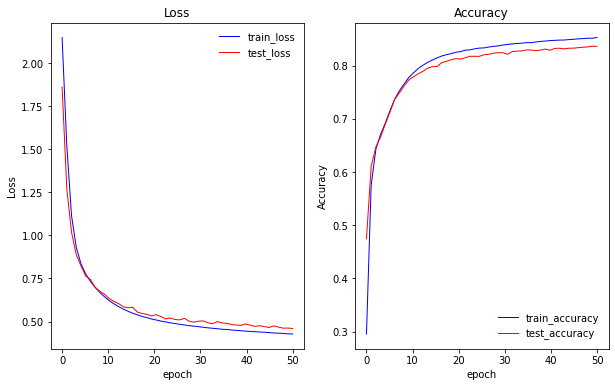

In [21]:
# 参数配置
device = 'cpu'
input_size = 28 * 28
hidden_size = 256
output_size = 10

batch_size = 256
num_epochs = 50
lr = 0.01

net = TorchNeuron(input_size, hidden_size, output_size)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(num_epochs):
    train_data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

    train_loss, train_acc = train_epoch(data_loader=train_data_loader, net=net,
                                        loss_func=loss_func, optimizer=optimizer, device=device)
    test_loss, test_acc = test_epoch(data_loader=test_data_loader, net=net,
                                     loss_func=loss_func, device=device)

    print('epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
          % (epoch+1, train_loss, test_loss, train_acc, test_acc))

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

plot_loss_accuracy(train_loss_list, train_acc_list, test_loss_list, test_acc_list)


#### 对比试验

##### 激活函数
在多分类实验的基础上使用至少三种不同的激活函数，对比使用不同激活函数的实验结果

lr=0.01 epoch 1, train_loss 0.528044, test_loss 0.460460, train_acc 0.807550, test_acc 0.828000
lr=0.01 epoch 2, train_loss 0.380905, test_loss 0.403512, train_acc 0.860233, test_acc 0.857300
lr=0.01 epoch 3, train_loss 0.345915, test_loss 0.384809, train_acc 0.872617, test_acc 0.861300
lr=0.01 epoch 4, train_loss 0.327341, test_loss 0.419251, train_acc 0.879117, test_acc 0.854600
lr=0.01 epoch 5, train_loss 0.315523, test_loss 0.396689, train_acc 0.882867, test_acc 0.856900
lr=0.01 epoch 6, train_loss 0.304076, test_loss 0.364707, train_acc 0.887617, test_acc 0.867600
lr=0.01 epoch 7, train_loss 0.295543, test_loss 0.362988, train_acc 0.890467, test_acc 0.872200
lr=0.01 epoch 8, train_loss 0.286296, test_loss 0.377438, train_acc 0.894033, test_acc 0.867100
lr=0.01 epoch 9, train_loss 0.281638, test_loss 0.384687, train_acc 0.895217, test_acc 0.871600
lr=0.01 epoch 10, train_loss 0.272300, test_loss 0.411203, train_acc 0.899533, test_acc 0.868400
lr=0.01 epoch 11, train_loss 0.271214, 

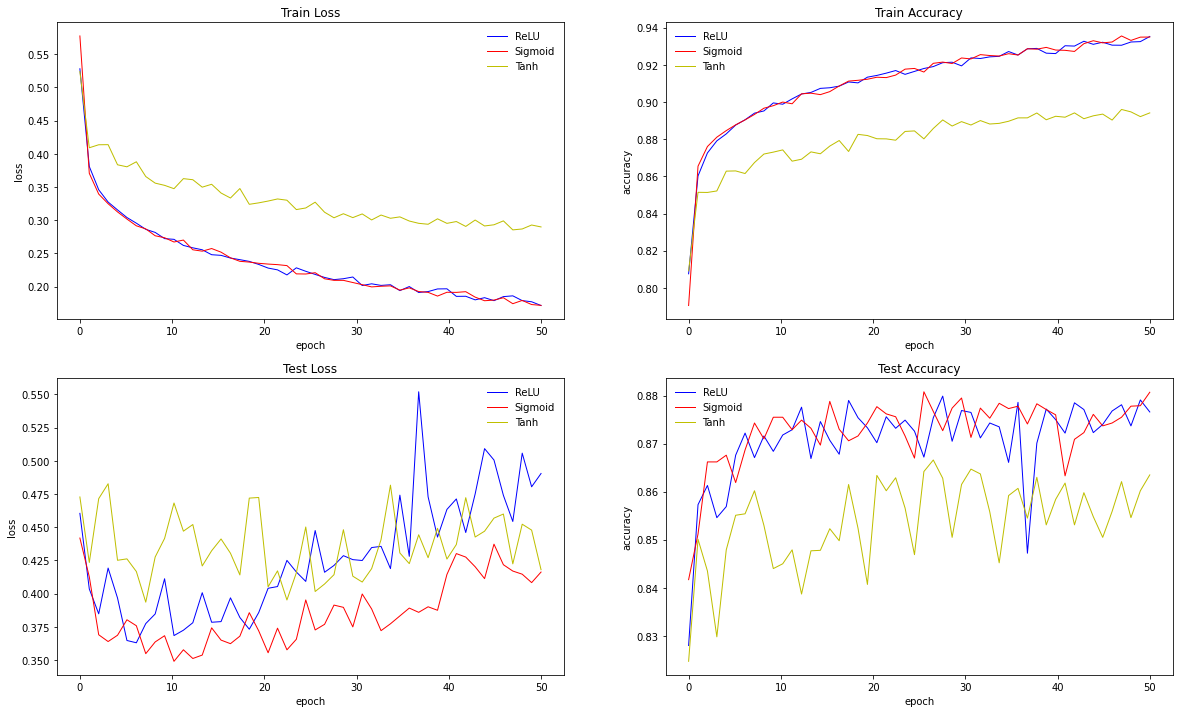

In [14]:
# 参数配置
device = 'cpu'
input_size = 28 * 28
hidden_size = 256
output_size = 10

batch_size = 256
num_epochs = 50
lr = 0.01

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

metric_dic = {
    'Train Loss': {},
    'Train Accuracy': {},
    'Test Loss': {},
    'Test Accuracy': {},
}

for activation in [nn.ReLU(), nn.Sigmoid(), nn.Tanh()]:

    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []

    net = TorchNeuron(input_size, hidden_size, output_size, activation=activation)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        train_data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
        test_data_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

        train_loss, train_acc = train_epoch(data_loader=train_data_loader, net=net,
                                            loss_func=loss_func, optimizer=optimizer, device=device)
        test_loss, test_acc = test_epoch(data_loader=test_data_loader, net=net,
                                         loss_func=loss_func, device=device)

        print('lr=%s epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
              % (lr, epoch+1, train_loss, test_loss, train_acc, test_acc))

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

    metric_dic['Train Loss'][activation._get_name()] = train_loss_list
    metric_dic['Train Accuracy'][activation._get_name()] = train_acc_list
    metric_dic['Test Loss'][activation._get_name()] = test_loss_list
    metric_dic['Test Accuracy'][activation._get_name()] = test_acc_list

plot_by_dict(metric_dic, shape=(2, 2))



##### 隐藏层层数
使用不同的隐藏层层数和隐藏单元个数，进行对比实验并分析实验结果

TorchNeuron(
  (linear): Sequential(
    (0): FlattenLayaer()
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)
lr=0.01 epoch 1, train_loss 0.521027, test_loss 0.461553, train_acc 0.809333, test_acc 0.835900
lr=0.01 epoch 2, train_loss 0.371831, test_loss 0.430478, train_acc 0.864233, test_acc 0.837700
lr=0.01 epoch 3, train_loss 0.337281, test_loss 0.427192, train_acc 0.876483, test_acc 0.844000
lr=0.01 epoch 4, train_loss 0.322860, test_loss 0.376169, train_acc 0.881483, test_acc 0.861500
lr=0.01 epoch 5, train_loss 0.309747, test_loss 0.370543, train_acc 0.886800, test_acc 0.872400
lr=0.01 epoch 6, train_loss 0.299056, test_loss 0.372532, train_acc 0.889400, test_acc 0.872700
lr=0.01 epoch 7, train_loss 0.288376, test_loss 0.357149, train_acc 0.894300, test_acc 0.876100
lr=0.01 epoch 8, train_loss 0.282418, test_loss 0.380399, train_acc 0.895967, test_acc 0.873000
lr=0.01 epoch 9, train_lo

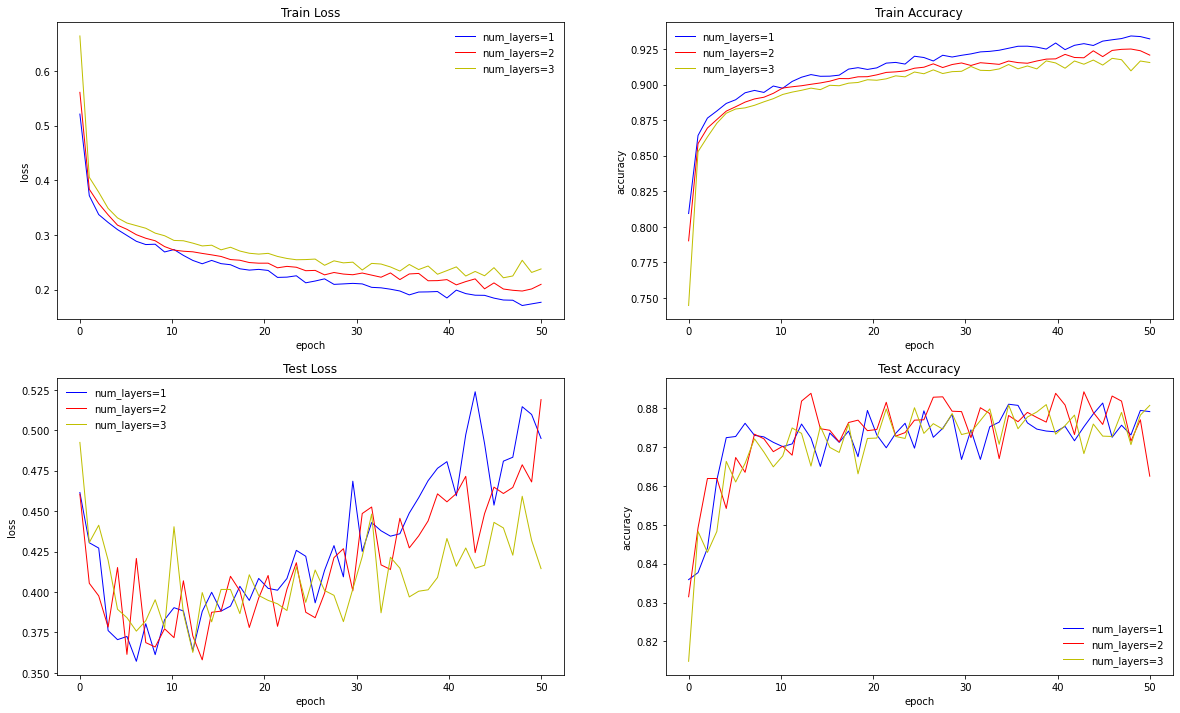

In [31]:
# 参数配置
device = 'cpu'
input_size = 28 * 28
hidden_size = 256
output_size = 10

batch_size = 256
num_epochs = 50
lr = 0.01

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

metric_dic = {
    'Train Loss': {},
    'Train Accuracy': {},
    'Test Loss': {},
    'Test Accuracy': {},
}

for num_layers in [1, 2, 3]:

    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []

    net = TorchNeuron(input_size, hidden_size, output_size, num_layers=num_layers)
    print(net)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        train_data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
        test_data_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

        train_loss, train_acc = train_epoch(data_loader=train_data_loader, net=net,
                                            loss_func=loss_func, optimizer=optimizer, device=device)
        test_loss, test_acc = test_epoch(data_loader=test_data_loader, net=net,
                                         loss_func=loss_func, device=device)

        print('lr=%s epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
              % (lr, epoch+1, train_loss, test_loss, train_acc, test_acc))

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

    metric_dic['Train Loss'][f'num_layers={num_layers}'] = train_loss_list
    metric_dic['Train Accuracy'][f'num_layers={num_layers}'] = train_acc_list
    metric_dic['Test Loss'][f'num_layers={num_layers}'] = test_loss_list
    metric_dic['Test Accuracy'][f'num_layers={num_layers}'] = test_acc_list

plot_by_dict(metric_dic, shape=(2, 2))



##### 隐藏单元个数
使用不同的隐藏层层数和隐藏单元个数，进行对比实验并分析实验结果

TorchNeuron(
  (linear): Sequential(
    (0): FlattenLayaer()
    (1): Linear(in_features=784, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=10, bias=True)
  )
)
lr=0.01 epoch 1, train_loss 0.580303, test_loss 0.470126, train_acc 0.792683, test_acc 0.835800
lr=0.01 epoch 2, train_loss 0.403906, test_loss 0.410601, train_acc 0.855217, test_acc 0.847000
lr=0.01 epoch 3, train_loss 0.369669, test_loss 0.419431, train_acc 0.866517, test_acc 0.849100
lr=0.01 epoch 4, train_loss 0.347058, test_loss 0.383698, train_acc 0.874433, test_acc 0.862500
lr=0.01 epoch 5, train_loss 0.334963, test_loss 0.400214, train_acc 0.878350, test_acc 0.856300
lr=0.01 epoch 6, train_loss 0.323980, test_loss 0.388322, train_acc 0.883583, test_acc 0.862900
lr=0.01 epoch 7, train_loss 0.321546, test_loss 0.392007, train_acc 0.881217, test_acc 0.858600
lr=0.01 epoch 8, train_loss 0.312150, test_loss 0.389947, train_acc 0.884800, test_acc 0.857100
lr=0.01 epoch 9, train_loss

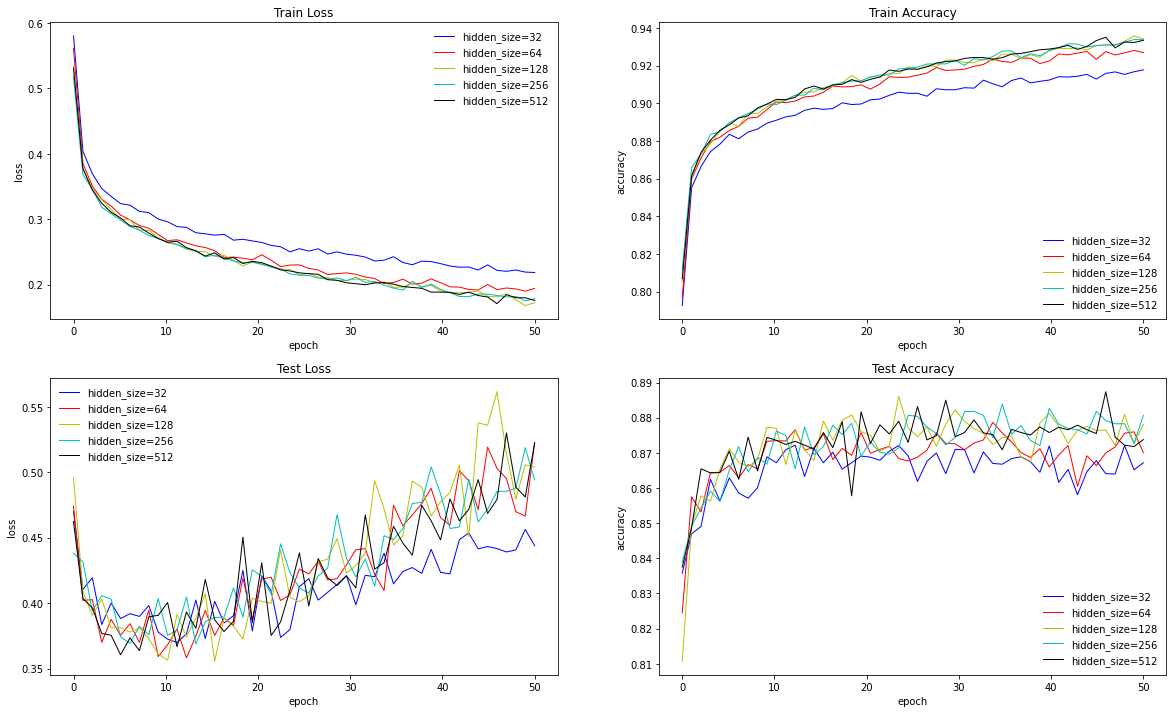

In [32]:
# 参数配置
device = 'cpu'
input_size = 28 * 28
hidden_size = 256
output_size = 10

batch_size = 256
num_epochs = 50
lr = 0.01

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

metric_dic = {
    'Train Loss': {},
    'Train Accuracy': {},
    'Test Loss': {},
    'Test Accuracy': {},
}

for hidden_size in [32, 64, 128, 256, 512]:

    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []

    net = TorchNeuron(input_size, hidden_size, output_size)
    print(net)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        train_data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
        test_data_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

        train_loss, train_acc = train_epoch(data_loader=train_data_loader, net=net,
                                            loss_func=loss_func, optimizer=optimizer, device=device)
        test_loss, test_acc = test_epoch(data_loader=test_data_loader, net=net,
                                         loss_func=loss_func, device=device)

        print('lr=%s epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
              % (lr, epoch+1, train_loss, test_loss, train_acc, test_acc))

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

    metric_dic['Train Loss'][f'hidden_size={hidden_size}'] = train_loss_list
    metric_dic['Train Accuracy'][f'hidden_size={hidden_size}'] = train_acc_list
    metric_dic['Test Loss'][f'hidden_size={hidden_size}'] = test_loss_list
    metric_dic['Test Accuracy'][f'hidden_size={hidden_size}'] = test_acc_list

plot_by_dict(metric_dic, shape=(2, 2))



##### 丢弃率(dropout)
+ 在多分类任务实验中分别手动实现和用torch.nn实现dropout
+ 探究不同`丢弃率`对实验结果的影响(可用loss曲线进行展示)

In [26]:
def dropout(x: torch.Tensor, dropout_prob=0.5):
    """
    丢弃率(失活率)
    设丢弃概率为p, 那么有p的概率 Hidden_i 会被清零，
    有1−p的概率 Hidden_i 会除以 1−p 做拉伸。
    """
    x = x.float()

    # 检查丢弃率是否在 0-1 之间
    assert 0 <= dropout_prob <= 1
    keep_prob = 1 - dropout_prob
    if keep_prob == 0:
        return torch.zeros_like(x)

    # 生成 mask 矩阵(向量)
    mask = (torch.randn(x.shape) < keep_prob).float()

    # 按照 mask 对 x 进行变换
    return mask * x / keep_prob


TorchNeuron(
  (linear): Sequential(
    (0): FlattenLayaer()
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)
lr=0.01 epoch 1, train_loss 0.529511, test_loss 0.434284, train_acc 0.806200, test_acc 0.838600
lr=0.01 epoch 2, train_loss 0.377324, test_loss 0.446387, train_acc 0.862950, test_acc 0.844600
lr=0.01 epoch 3, train_loss 0.352689, test_loss 0.406702, train_acc 0.870550, test_acc 0.858800
lr=0.01 epoch 4, train_loss 0.329997, test_loss 0.398869, train_acc 0.878400, test_acc 0.858300
lr=0.01 epoch 5, train_loss 0.314999, test_loss 0.379586, train_acc 0.883467, test_acc 0.869200
lr=0.01 epoch 6, train_loss 0.300563, test_loss 0.385892, train_acc 0.887567, test_acc 0.864400
lr=0.01 epoch 7, train_loss 0.292847, test_loss 0.369948, train_acc 0.891067, test_acc 0.875400
lr=0.01 epoch 8, train_loss 0.288393, test_loss 0.372619, train_acc 0.893667, test

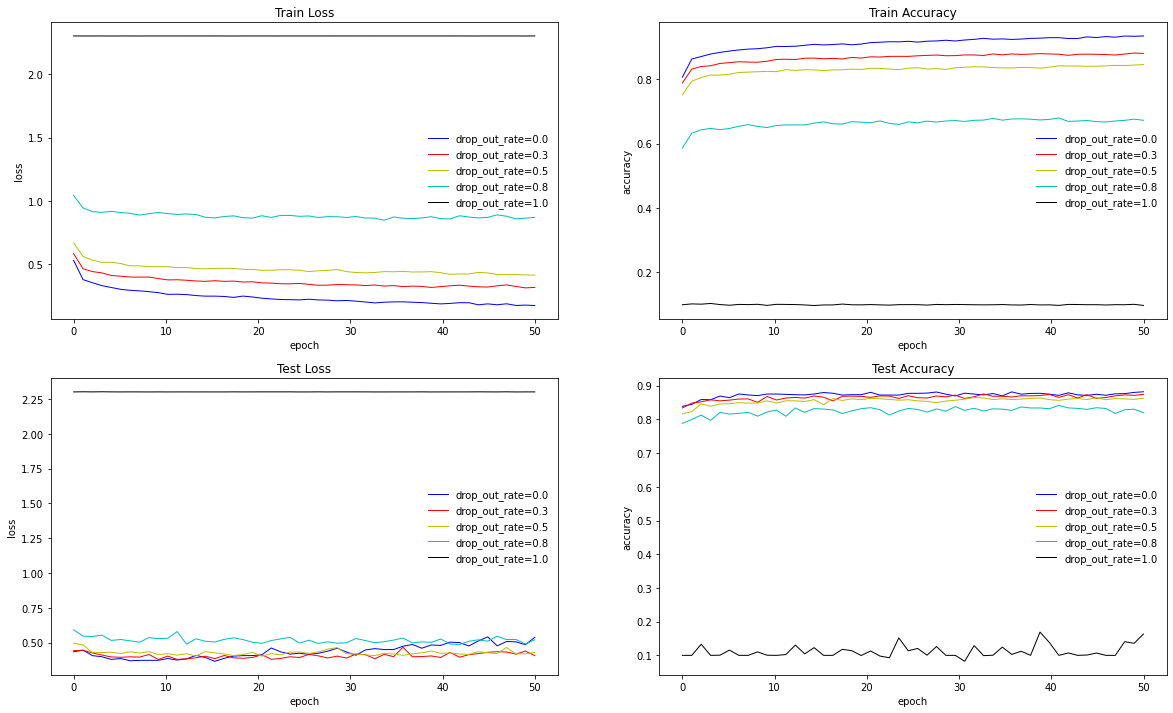

In [34]:
# 参数配置
device = 'cpu'
input_size = 28 * 28
hidden_size = 128
output_size = 10

batch_size = 256
num_epochs = 50
lr = 0.01

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

metric_dic = {
    'Train Loss': {},
    'Train Accuracy': {},
    'Test Loss': {},
    'Test Accuracy': {},
}

for drop_out_rate in [0.0, 0.3, 0.5, 0.8, 1.0]:

    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []

    net = TorchNeuron(input_size, hidden_size, output_size, drop_out_rate=drop_out_rate)
    print(net)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        train_data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
        test_data_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

        train_loss, train_acc = train_epoch(data_loader=train_data_loader, net=net,
                                            loss_func=loss_func, optimizer=optimizer, device=device)
        test_loss, test_acc = test_epoch(data_loader=test_data_loader, net=net,
                                         loss_func=loss_func, device=device)

        print('lr=%s epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
              % (lr, epoch+1, train_loss, test_loss, train_acc, test_acc))

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

    metric_dic['Train Loss'][f'drop_out_rate={drop_out_rate}'] = train_loss_list
    metric_dic['Train Accuracy'][f'drop_out_rate={drop_out_rate}'] = train_acc_list
    metric_dic['Test Loss'][f'drop_out_rate={drop_out_rate}'] = test_loss_list
    metric_dic['Test Accuracy'][f'drop_out_rate={drop_out_rate}'] = test_acc_list

plot_by_dict(metric_dic, shape=(2, 2))

##### 在多分类任务实验中分别手动实现和用torch.nn实现𝑳𝟐正则化
探究惩罚项的权重对实验结果的影响(可用loss曲线进行展示)

TorchNeuron(
  (linear): Sequential(
    (0): FlattenLayaer()
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)
lr=0.01 epoch 1, train_loss 0.524892, test_loss 0.435192, train_acc 0.806333, test_acc 0.853000
lr=0.01 epoch 2, train_loss 0.378659, test_loss 0.395001, train_acc 0.862900, test_acc 0.859100
lr=0.01 epoch 3, train_loss 0.352307, test_loss 0.413986, train_acc 0.870467, test_acc 0.851400
lr=0.01 epoch 4, train_loss 0.325388, test_loss 0.362763, train_acc 0.881667, test_acc 0.872200
lr=0.01 epoch 5, train_loss 0.315034, test_loss 0.372450, train_acc 0.884983, test_acc 0.863200
lr=0.01 epoch 6, train_loss 0.306408, test_loss 0.360257, train_acc 0.887250, test_acc 0.872600
lr=0.01 epoch 7, train_loss 0.289946, test_loss 0.389846, train_acc 0.893817, test_acc 0.860000
lr=0.01 epoch 8, train_loss 0.284421, test_loss 0.382306, train_acc 0.895167, test_a

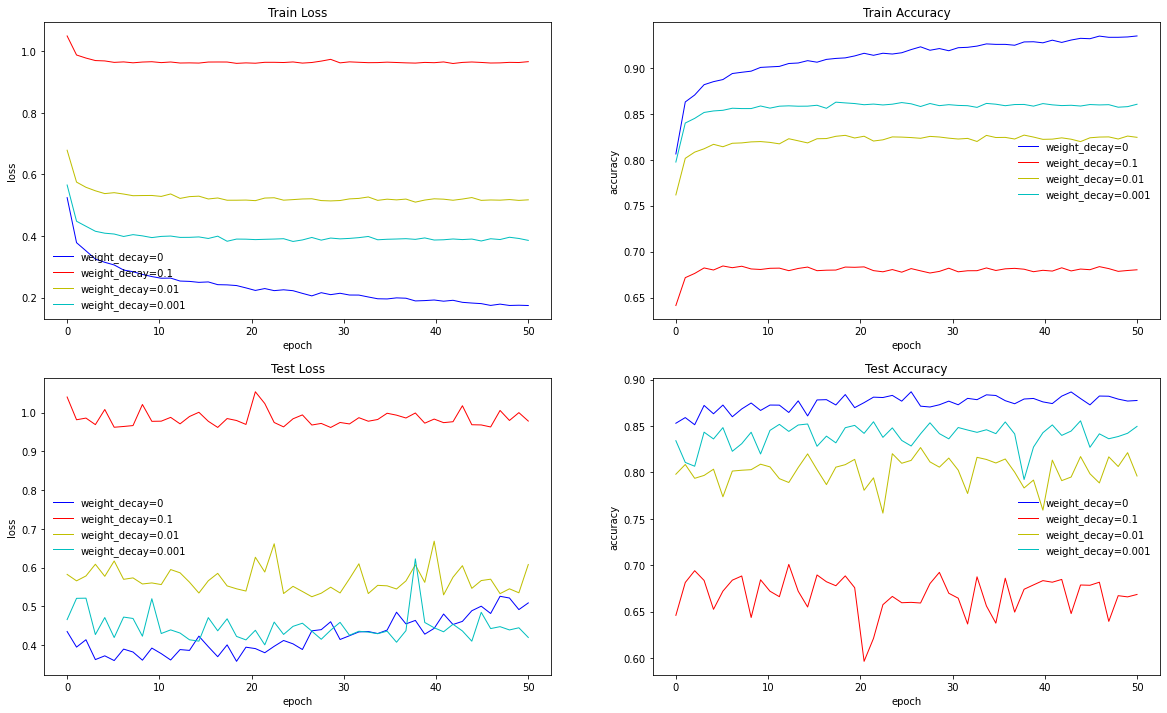

In [35]:
# 参数配置
device = 'cpu'
input_size = 28 * 28
hidden_size = 128
output_size = 10

batch_size = 256
num_epochs = 50
lr = 0.01

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

metric_dic = {
    'Train Loss': {},
    'Train Accuracy': {},
    'Test Loss': {},
    'Test Accuracy': {},
}

for weight_decay in [0, 0.1, 0.01, 0.001]:

    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []

    net = TorchNeuron(input_size, hidden_size, output_size)
    print(net)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        train_data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
        test_data_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

        train_loss, train_acc = train_epoch(data_loader=train_data_loader, net=net,
                                            loss_func=loss_func, optimizer=optimizer, device=device)
        test_loss, test_acc = test_epoch(data_loader=test_data_loader, net=net,
                                         loss_func=loss_func, device=device)

        print('lr=%s epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
              % (lr, epoch+1, train_loss, test_loss, train_acc, test_acc))

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

    metric_dic['Train Loss'][f'weight_decay={weight_decay}'] = train_loss_list
    metric_dic['Train Accuracy'][f'weight_decay={weight_decay}'] = train_acc_list
    metric_dic['Test Loss'][f'weight_decay={weight_decay}'] = test_loss_list
    metric_dic['Test Accuracy'][f'weight_decay={weight_decay}'] = test_acc_list

plot_by_dict(metric_dic, shape=(2, 2))

##### 采用10折交叉验证评估实验结果
要求除了最终结果外还需以表格的形式展示每折的实验结果

In [29]:
import torch
from sklearn.model_selection import KFold


def train(train_x, train_y, test_x, test_y):
    net = TorchNeuron(input_size, hidden_size, output_size)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []

    for epoch in range(num_epochs):

        train_set = Data.TensorDataset(train_x, train_y)
        test_set = Data.TensorDataset(test_x, test_y)

        train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        test_data_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

        train_loss, train_acc = train_epoch(data_loader=train_data_loader, net=net,
                                            loss_func=loss_func, optimizer=optimizer, device=device)
        test_loss, test_acc = test_epoch(data_loader=test_data_loader, net=net,
                                         loss_func=loss_func, device=device)

        print('epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
              % (epoch+1, train_loss, test_loss, train_acc, test_acc))

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

    return train_loss_list, train_acc_list, test_loss_list, test_acc_list

# 参数配置
device = 'cpu'
input_size = 28 * 28
hidden_size = 128
output_size = 10

batch_size = 256
num_epochs = 20
lr = 0.01

X = torch.cat([mnist_train.data, mnist_test.data], dim=0)
y = torch.cat([mnist_train.targets, mnist_test.targets], dim=0)
print(X.shape, y.shape)

indices = np.arange(0, X.shape[0])
kf = KFold(n_splits=10)

kf_train_loss, kf_train_acc, kf_test_loss, kf_test_acc = [], [], [], []
for train_index, test_index in kf.split(indices):
    train_index = torch.LongTensor(train_index)
    test_index = torch.LongTensor(test_index)

    train_x = torch.index_select(X, dim=0, index=train_index)
    train_y = torch.index_select(y, dim=0, index=train_index)
    test_x = torch.index_select(X, dim=0, index=test_index)
    test_y = torch.index_select(y, dim=0, index=test_index)

    # 训练
    train_loss_list, train_acc_list, \
    test_loss_list, test_acc_list = train(train_x, train_y, test_x, test_y)

    kf_train_loss.append(train_loss_list)
    kf_train_acc.append(train_acc_list)
    kf_test_loss.append(test_loss_list)
    kf_test_acc.append(test_acc_list)


torch.Size([70000, 28, 28]) torch.Size([70000])
epoch 1, train_loss 3.625947, test_loss 1.756168, train_acc 0.291571, test_acc 0.334000
epoch 2, train_loss 1.750988, test_loss 1.662811, train_acc 0.297587, test_acc 0.347000
epoch 3, train_loss 1.621198, test_loss 1.583366, train_acc 0.349714, test_acc 0.373000
epoch 4, train_loss 1.626835, test_loss 1.610424, train_acc 0.349683, test_acc 0.374143
epoch 5, train_loss 1.638005, test_loss 2.345621, train_acc 0.345825, test_acc 0.291714
epoch 6, train_loss 1.733139, test_loss 1.675032, train_acc 0.339111, test_acc 0.311429
epoch 7, train_loss 1.614935, test_loss 1.694614, train_acc 0.354048, test_acc 0.357714
epoch 8, train_loss 1.627564, test_loss 1.682208, train_acc 0.357762, test_acc 0.318143
epoch 9, train_loss 1.650702, test_loss 1.749844, train_acc 0.357810, test_acc 0.308286
epoch 10, train_loss 1.610449, test_loss 1.903641, train_acc 0.356857, test_acc 0.274429
epoch 11, train_loss 1.640706, test_loss 1.757889, train_acc 0.351762, 

In [36]:
kf_train_loss_np = np.array(kf_train_loss)
kf_train_acc_np = np.array(kf_train_acc)

kf_test_loss_np = np.array(kf_test_loss)
kf_test_acc_np = np.array(kf_test_acc)

# print(kf_test_loss_np.min(axis=1))
# print(kf_test_loss_np.mean(axis=1))

# print(kf_test_acc_np.max(axis=1))

print('Average Loss    :', list(round(i, ndigits=3) for i in kf_test_loss_np.mean(axis=1)))
print('Average Accuracy:', list(round(i, ndigits=3) for i in kf_test_acc_np.mean(axis=1)))

Average Loss    : [1.746, 1.481, 2.196, 1.904, 1.887, 1.366, 1.518, 1.851, 1.267, 1.732]
Average Accuracy: [0.34, 0.43, 0.168, 0.263, 0.267, 0.443, 0.412, 0.287, 0.484, 0.34]
